    Copyright (C) 2003 Mikhail Schirokikh
                       <github.com/arabel1a>


    This code is free software; you can redistribute it and/or
    modify it under the terms of version 3 of the GNU Library General
    Public License as published by the Free Software Foundation.
    This library is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.
    You should have received a copy of the GNU Library General Public
    License along with this library; if not, write to the Free Software
    Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.
    THE AUTHORS OF THIS LIBRARY ACCEPT ABSOLUTELY NO LIABILITY FOR
    ANY HARM OR LOSS RESULTING FROM ITS USE.  IT IS _EXTREMELY_ UNWISE
    TO RELY ON SOFTWARE ALONE FOR SAFETY.  Any machinery capable of
    harming persons must have provisions for completely removing power
    from all motors, etc, before persons enter any danger area.  All
    machinery must be designed to comply with local and national safety
    codes, and the author of this software can not, and do not, take
    any responsibility for such compliance.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

f_0 = 100            # starting speed
f_c = 1000           # target speed
max_t_c = 1         # maximum time for acceleration
c = 1500             # maximum acceleration
eps = 0.001         # just a little constant
curr_pos   = 0      # in (micro)steps
target_pos = -1000   # in (micro)steps
ksi        = 100     # steps away of center to be reached target speed



def v1(x):
    return f_0 + a * x **2


def n1 (x, k=0):
    return f_0 * x + a * x**3/3 - k


def v2(x):
    return c*x + d


def n2 (x, k=0):
    return c * x ** 2/2 + d * x - \
        c * t_1**2/2 - d * t_1 + \
        N_1[-1] - k

def v3(x):
    return -a*(x - t_c) ** 2+ f_c


def n3(x, k=0):
    return f_c * x - a * (x - t_c)**3/3-\
      f_c * (t_c - t_1) + a * (t_c - t_1 - t_c)**3/3  +\
      N_2[-1] - k



In [2]:
# Trajectory planner: finds the best accuracy profile. See main.c for more detailed description.

path       = abs(curr_pos - target_pos)
_dir = np.sign(target_pos - curr_pos)


if f_c <= f_0:
    f_0 = f_c - 1;

N_1 = np.zeros(1)
N_2 = np.zeros(1)
tcl = 0
tcr = max_t_c
while(tcr - tcl > 0.01):
    t_c = (tcl + tcr) / 2
    a =  -(c ** 2) / (2 * (f_c - f_0 - c * t_c))
    d = f_0 - c ** 2 / (4*a)
    t_1 = c / (2*a)
    N_1[-1] = n1(t_1)
    N_2[-1] = n2(t_c - t_1)
    N_3 = n3(t_c)
    if(N_3 > path/2 - ksi):
        tcr = t_c
    else:
        tcl = t_c

        
if(f_c - f_0 - c*t_c > 0 or N_1[-1] < 3 or N_3 - N_2[-1] < 3):
    print("Error: can not reach target speed from current position. Target speed will be reduced.");
    f_cr = c*max_t_c + f_0 - 10
    f_cl = 0
    while(f_cr - f_cl > 1):
        f_c = (f_cr + f_cl) / 2
        N_1 = np.zeros(1)
        N_2 = np.zeros(1)
        tcl = 0
        tcr = max_t_c
        while(tcr - tcl > 0.01):
            t_c = (tcl + tcr) / 2
            a =  -(c ** 2) / (2 * (f_c - f_0 - c * t_c))
            d = f_0 - c ** 2 / (4*a)
            t_1 = c / (2*a)
            N_1[-1] = n1(t_1)
            N_2[-1] = n2(t_c - t_1)
            N_3 = n3(t_c)
            if(N_3 > path/2 - ksi):
                tcr = t_c
            else:
                tcl = t_c

        if(f_c - f_0 - c*t_c > 0 or N_1[-1] < 3 or N_3 - N_2[-1] < 3):
            f_cr = f_c
        else:
            f_cl = f_c

print("Target speed:", f_c,"Acceleration time:", t_c)


Target speed: 1000 Acceleration time: 0.7265625


Switching point 0.1265625


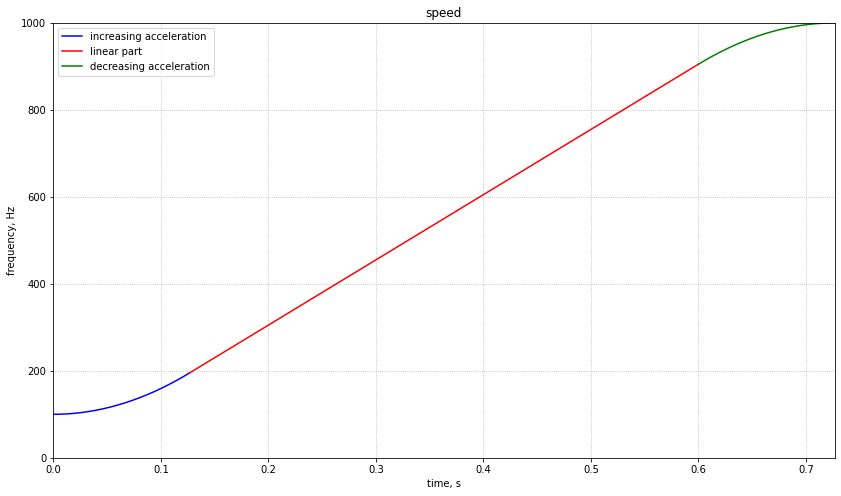

In [3]:
# Plot the spped curve during acceleration

x = np.linspace(0, 10, 10000)
 
fig = plt.figure(figsize = (14, 8))

if f_c - f_0 - c*t_c > 0:
    t_c = (f_c - f_0) / c + eps
    print("warning: accelerating time will be greater than commanded. Try increasing parameter 'c'")
if c > (2 * f_c - 2*f_0)  / t_c:
    c = (2 * f_c - 2*f_0)  / t_c
    print("warning: maximal acceleration is never reached. You can decrease acceleration time")
a =  -(c ** 2) / (2 * (f_c - f_0 - c * t_c))
d = f_0 - c ** 2 / (4*a)
t_1 = c / (2*a)
print ("Switching point", t_1)

x1 = np.linspace(0, t_1, 10000)
y1 = v1(x1)
plt.plot(x1, y1, 'b', label ='increasing acceleration')


x2 = np.linspace(t_1, t_c - t_1, 10000)
y2 = v2(x2)
plt.plot(x2, y2, 'r', label ='linear part')

x3 = np.linspace(t_c - t_1, t_c, 10000)
y3 = v3(x3)
plt.plot(x3, y3, 'g', label ='decreasing acceleration')

plt.legend()
plt.grid(True, linestyle =':')
plt.xlim([0, t_c])
plt.ylim([0, f_c])
 
plt.title('speed')
plt.xlabel('time, s')
plt.ylabel('frequency, Hz')
 
plt.show()

total pulses: 399.609375


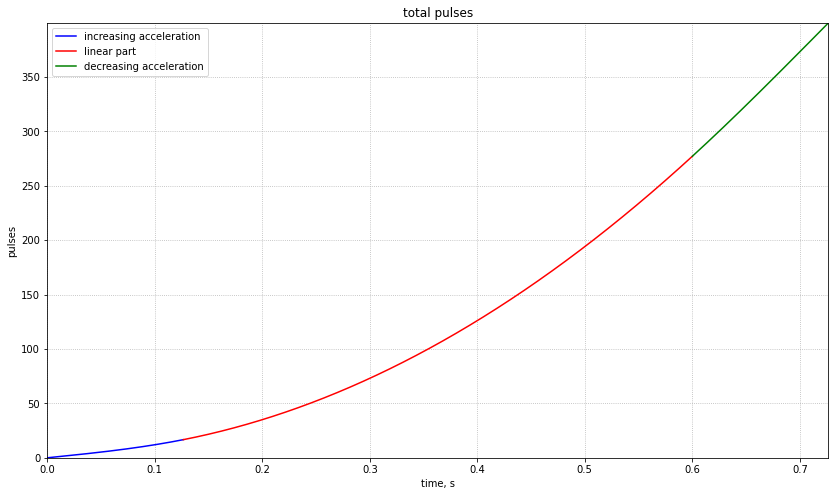

In [4]:
#Plot position curve suring acceleration

fig = plt.figure(figsize = (14, 8))

N_1 = n1(x1)
plt.plot(x1, N_1, 'b', label ='increasing acceleration')
N_2 = n2(x2)
plt.plot(x2, N_2, 'r', label ='linear part')
N_3 = n3(x3)

print('total pulses:', N_3[-1])
plt.plot(x3, N_3, 'g', label ='decreasing acceleration')
plt.legend()
plt.grid(True, linestyle =':')
plt.xlim([0, t_c])
plt.ylim([0, N_3[-1]])
 
plt.title('total pulses')
plt.xlabel('time, s')
plt.ylabel('pulses')
 
plt.show()


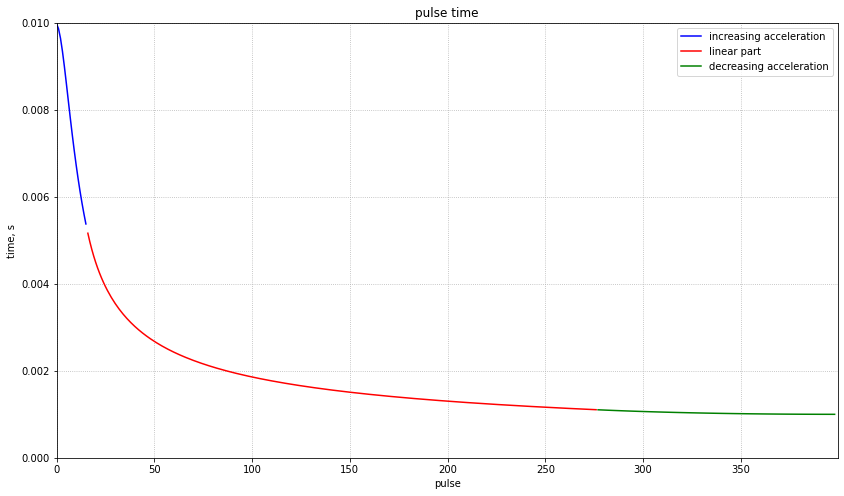

In [5]:
# Plot the discretized step pulse duration

newton_iterations = 10

fig = plt.figure(figsize = (14, 8))
p1 = np.linspace(0, N_1.astype(int)[-1], N_1.astype(int)[-1] + 1)
ttim1 = np.ones_like(p1) * 1/f_0 + eps
for i in range (newton_iterations):
    ttim1 = ttim1 - n1(ttim1, p1) / v1(ttim1) 
tim1 = ttim1 - np.roll(ttim1, 1)
tim1 = tim1[1:]
p1 = p1[1:] - 1
timings = np.array([1/f_0]);
timings = np.concatenate((timings, tim1), axis=0)
    
plt.plot(p1, tim1, 'b', label ='increasing acceleration')


p2 = np.linspace(N_1.astype(int)[-1], N_2.astype(int)[-1], N_2.astype(int)[-1] + 1 - N_1.astype(int)[-1])
ttim2 = np.ones_like(p2) * ttim1[-1]
for i in range (newton_iterations):
    ttim2 = ttim2 - n2(ttim2, p2) / v2(ttim2) 
tim2 = ttim2 - np.roll(ttim2, 1)
tim2 = tim2[1:]
p2 = p2[1:] - 1
timings = np.concatenate((timings, tim2), axis=0)
plt.plot(p2, tim2, 'r', label ='linear part')

p3 = np.linspace(N_2.astype(int)[-1], N_3.astype(int)[-1], N_3.astype(int)[-1] + 1 - N_2.astype(int)[-1])
ttim3 = np.ones_like(p3) * ttim2[-1]
for i in range (newton_iterations):
    ttim3 = ttim3 - n3(ttim3, p3) / v3(ttim3) 
tim3 = ttim3 - np.roll(ttim3, 1)
#tim3[0] = tim2[-1]
tim3 = tim3[1:]
p3 = p3[1:] - 1

plt.plot(p3, tim3, 'g', label ='decreasing acceleration')
timings = np.concatenate((timings, tim3), axis =0)

# Add features to our figure
plt.legend()
plt.grid(True, linestyle =':')
plt.xlim([0, N_3[-1]])
plt.ylim([0, 1/f_0])

 
plt.title('pulse time')
plt.xlabel('pulse')
plt.ylabel('time, s')
 
# Show plot
plt.show()


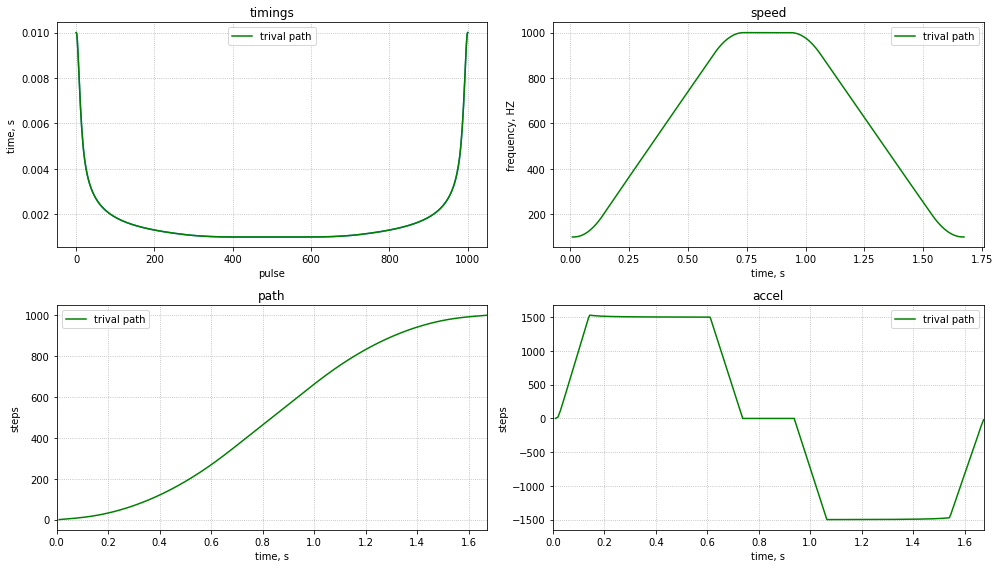

In [6]:
# Same plots, but for the whole path
    
xt = np.linspace(0, path, path + 1)
T = np.zeros_like(xt)
for i in range(path + 1):
    if i < N_3[-1] - 1:
        T[i] = timings[i]
    elif i < path - N_3[-1] + 1:
        T[i] = 1/f_c
    else:
        T[i] = timings[int(path - i)]

        
fig, axs = plt.subplots(2, 2, figsize = (14, 8))


axs[0, 0].plot(xt, T)
axs[0, 0].set_title("timings")
axs[0, 0].plot(xt, T, 'g', label ='trival path')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle =':')
axs[0, 0].set_xlabel('pulse')
axs[0, 0].set_ylabel('time, s')


time = np.cumsum(T)
axs[0, 1].set_title("speed")
axs[0, 1].plot(time, 1/T, 'g', label ='trival path')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle =':')
axs[0, 1].set_xlabel('time, s')
axs[0, 1].set_ylabel('frequency, HZ')

time = np.cumsum(T)
axs[1, 0].set_title("path")
axs[1, 0].plot(time, xt, 'g', label ='trival path')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle =':')
axs[1, 0].set_xlabel('time, s')
axs[1, 0].set_xlim([0, time[-1]])
axs[1, 0].set_ylabel('steps')

axs[1, 1].set_title("accel")
axs[1, 1].plot(time, (1/T - 1/np.roll(T,1)) / T, 'g', label ='trival path')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle =':')
axs[1, 1].set_xlabel('time, s')
axs[1, 1].set_xlim([0, time[-1]])
axs[1, 1].set_ylabel('steps')

fig.tight_layout()